---
# House Pricing Prediction
---

# Group 20 : Solution
## by Clément Bernard,Brugeres Maxence and Martin Guyard 



We aim with this challenge to predict the price of a house, knowing few features. 
<br>
We have around 81 features that describe the house. These features are not clean, all relevant, and sometimes redundant. 
<br>
To train a model, we have 1200 inputs and 260 to test it. 
<br> We decided to clean our data (by dealing with NaN values and outliers), then to do some features selection and encode them as either ordinal encoding or K encoding. 
<br>
Then, we worked on the model selection to predict the price of houses.


# Data pre-processing

## Features selection

### Missing values


Let's see the top 5 percentage of <b> missing values </b> for the features.
<br>
Indeed, if there are features with too much missing values, there's no interest in keeping them.
    


In [5]:
# Print the features that have high ratio of NaN values
(dataset.isnull().sum()/dataset.shape[0]*100).sort_values(ascending = False).head(5)

PoolQC         99.666667
MiscFeature    96.083333
Alley          93.750000
Fence          81.083333
FireplaceQu    47.000000
dtype: float64

It will be hard to deal with features that have 99% of NaN values... 
<br>
So, we decided to remove the features that have more than 30 % missing values. 
<br>
Indeed, this choice is arbitrary and aims to have data that is correct and not fulfilled by false ones.


### Non relevant features


Then, let's see the correlation between features and the SalePrice (our label).
<br>
We needed to differentiate the numerical features from the categorical ones (non numeric). 
<br>
Here is the mutual information for non numeric features.


Text(0.5,1,'Mutual information for categorical features')

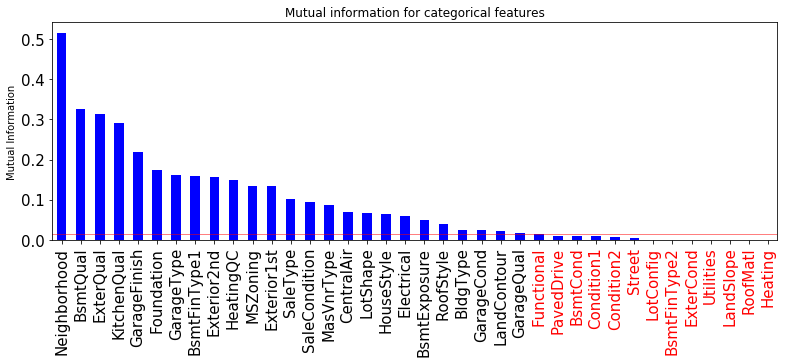

We simplify the data by dropping the features with a mutual information less than 0.015.
<br>
Indeed, this is an arbitrary choice.

We therefore dropped <b> 13 categorical features. </b> <br>
We did exactly the same for numerical features. We just replaced the threshold by a higher values (because numerical features have higher mutual information with the SalePrice than categorical features). <br>
We dropped in this way <b> 8 numerical features </b>.

### Redundant features


Let's see the correlation between features. Highly correlated features should be dropped because they contain the same information. <br>
Therefore, we made the threshold equal to 0.8 (arbitrary choice).


In [20]:
# Print the correlation (higher than 0.8) for correlated features

Feature 1                 Feature 2                 Correlation              
YearBuilt                 GarageYrBlt               0.839                    
TotalBsmtSF               1stFlrSF                  0.807                    
GrLivArea                 TotRmsAbvGrd              0.83                     
GarageCars                GarageArea                0.885                    




We dropped one set of features to avoid too much correlation between features.
<br>
For instance <b> YearBuilt </b> and <b> GarageYearBuilt </b> are not both necessary, only one should be kept. 
<br>
We then look to the correlation graph between SalePrice and those features, and we dropped the ones with lowest correlation with SalePrice.


## NaN values

Now that we have all the features we want to work on, let's work on these features. 
<br>
Few features have <b> missing values</b>. 
<br>
To decide how to replace them, we differentiated our approach whether the feature is <b> numerical </b> or <b> categorical (non numeric)</b>. 

### Numerical features



We handled <b> NaN </b>  values by taking the <b>mean</b>. <br>
 This is an arbitrary decision. We could have replaced by the previous value or by doing regression knowing the other features. 


### Categorical features



We handled <b> Nan </b> values by replacing it with a <b> None </b> string, which will basically add a feature when we'll do K-encoding.




## Vectorization of categorical features

Now that we don't have missing values anymore, let's find a way to convert our <b> categorical features </b> into <b> numerical ones </b> (for the models). 



We had two choices : either to use <b> ordinal encoding </b> (like 'bad' becomes 0, 'good' becomes 1, etc) or <b> K-encoding </b> (creation of binary categories).
<br>
<b> Ordinal encoding </b> is relevant if the feature represents a hierarchy.
<br>
On the other hand, <b> K-encoding </b> is relevant when there is no hierarchy between the category of a feature.


### Ordinal encoding 


To know which feature has a natural order, we analysed the categorical feature one by one.  <br>
After an analysis on the data, whenever there is a quality that comes, there is an order and therefore we converting it into integers makes sense. <br>
Let's see with an exemple : the feature <b> BsmtQual </b>. 




In [33]:
dataset['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', 'None', 'Fa'], dtype=object)

This is a feature which evaluates the height of the basement. <br>
If the height is high (100+ inches), the value encoded will be <b> 'Ex' </b> for <b> Excellent </b>. <br>
This is the same idea for <b>'Ta' : Typical</b> , <b> 'Gd' : Good </b>, etc. <br>
We considered it as an order and therefore we converted it into ordered numbers with the following dictionary : 


In [35]:
dic_ex = {'Po':0, 'Fa':1, 'None':2,'TA':3,'Gd':4,'Ex':5}

Note that the <b> None </b> value was before a <b> NaN </b> value, and so we considered it as an average quality (arbitrary choice). <br>
Now let's check the convertion was well done :

In [78]:
dataset['BsmtQual'].unique()

array([4, 3, 5, 2, 1])

We did this with other features by adapting the dictionnary. 

### K-encoding 

For the categorical features that don't have order, we K-encoded them. <br>
Let's see with an example. <br>
The feature <b> MSZoning </b> describes the general zoning of the sale. It can either be <b> Residential High Density (RH) </b>, <b> Commercial (C) </b>, and so on. <br>





In [79]:
dataset['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

We see here there is no order and therefore we created a new feature for each possibility (one for Residential High Density, one for Commercial, etc) with inside binary values (0 or 1).


Here is the result of the <b> K-encoding </b> for the feature <b> MSZoning </b> (we used the 'get_dummies' function)

In [83]:
pd.get_dummies(dataset['MSZoning'], prefix_sep='_', drop_first=False, prefix = 'MSZoning').head(3)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0


We did it for all features that didn't have an predefined order.

## Standardisation

We now have only <b>numerical values</b>. <br>
Nevertheless, some models need to have values that don't have too high values. Furthermore, a model doesn't have the knowledge of units.  <br>
That's why we decided to standardize our data. <br>
We only take into consideration the <b> continuous numerical features</b>. <br>
But let's have a look to the distribution of one of these features with the SalePrice.

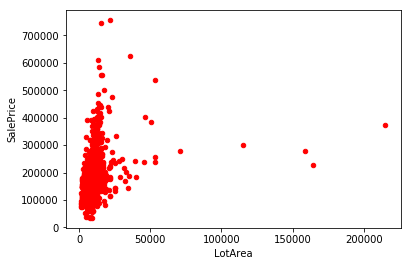

In [25]:
dataset.plot(kind = 'scatter', x='LotArea',y='SalePrice' , color = 'r')

We see that there are <b> outliers </b>. <br>
Even if there are only 4 outliers, it can have bad impact on the standardisation process (as we substract by the mean). <br>
So we dropped by hand all the outliers on these features.

## Convert into inputs and labels

Now that we have pre-processed our data, we need to convert them into <b> inputs </b>  and <b> targets </b>.
<br>
We used the <b> 'train.csv' </b> file as our training (where we could split it to have a validation set) and <b> 'test.csv' </b> as our testing set.  

# Model selection